<a href="https://colab.research.google.com/github/omararh/Expression-editor-assistant/blob/main/API_tinny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import json

def read_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    return json.load(f)

INPUT_DATA_BASE_PATH = 'input_data/'

AVAILABLE_CONTEXT = read_file(INPUT_DATA_BASE_PATH + 'context.json')

SYMFONY_EXAMPLES = read_file(INPUT_DATA_BASE_PATH + 'examples.json')

# Tokenisation & embedding

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import spacy
!python -m spacy download fr_core_news_md

# Load french tokenizer, tagger, parser
nlp = spacy.load('fr_core_news_md')

def get_embedding(text):
    """
    Get normalized average embedding of all tokens (filtered).
    """
    doc = nlp(text)
    vectors = np.array([token.vector for token in doc if token.has_vector and not token.is_stop and not token.is_punct])

    if len(vectors) == 0:
        return np.zeros((nlp.vocab.vectors_length,))

    avg_vector = np.mean(vectors, axis=0)
    return avg_vector / np.linalg.norm(avg_vector)


def select_relevant_examples(user_query, examples_dict, top_k=5):
    """
    Sélectionne les exemples les plus pertinents en fonction de la similarité
    d'embedding avec la requête utilisateur.

    Args:
        user_query: user request
        examples_dict: (description -> expression) examples
        top_k: K relevant examples to be returned

    Returns:
        K relevant examples
    """
    query_embedding = get_embedding(user_query)

    similarities = []

    for description, expression in examples_dict.items():
        desc_embedding = get_embedding(description)

        similarity = cosine_similarity([query_embedding], [desc_embedding])[0][0]
        similarities.append((similarity, description, expression))

    similarities.sort(reverse=True)
    top_examples = [(desc, expr) for _, desc, expr in similarities[:top_k]]

    return top_examples


# Prompt build

In [46]:
import requests
import time
from google.colab import userdata

# Configuration de l'API
API_URL = "https://api-inference.huggingface.co/models/TinyLlama/TinyLlama-1.1B-Chat-v1.0"
API_TOKEN = userdata.get('API_TOKEN')

headers = {
    "Authorization": f"Bearer {API_TOKEN}",
    "Content-Type": "application/json"
}

def generate_expression(user_intent, available_context=None, examples=None):
    """
    Génère une suggestion d'expression Symfony
    Args:
        user_intent (str): Intention ou question de l'utilisateur
        available_context (dict, optional): Contexte disponible dans l'éditeur
        examples (list, optional): Exemples d'expressions valides
    Returns:
        str: Expression Symfony suggérée par le modèle
    """
    # Construction du prompt
    prompt = _build_prompt(user_intent, available_context, examples)

    # Génération via l'API
    try:
        return _generate_with_api(prompt)
    except Exception as e:
        print(f"Erreur: {e}")
        return "Une erreur est survenue."

def _build_prompt(user_intent, available_context=None, examples=None):
    """Construit un prompt clair et minimaliste pour le modèle"""
    prompt = (
        "Tu es un assistant expert en Symfony Expression Language. "
        "Ta tâche est de générer une **seule** expression Symfony valide, sans aucune explication, "
        "en te basant uniquement sur le contexte et les exemples fournis.\n\n"
    )

    # Contexte disponible - limiter aux éléments essentiels
    if available_context:
        prompt += "Contexte :\n"
        for category, items in available_context.items():
            if category in ["ContextVars", "ContextActions", "Fonctions"]:  # Garder seulement les catégories essentielles
                if isinstance(items, dict):
                    prompt += f"- {category} :\n"
                    # Limiter à 5 items par catégorie
                    count = 0
                    for key, value in items.items():
                        if count < 5:
                            prompt += f"  * {key}: {value}\n"
                            count += 1
                        else:
                            break
                else:
                    prompt += f"- {category} : {', '.join(items[:5])}\n"  # Limiter à 5 items
        prompt += "\n"

    # Exemples pertinents - réduire à 3 exemples maximum
    if examples:
        prompt += "Exemples :\n"
        inverted_examples = {v: k for k, v in examples.items()}
        relevant_examples = select_relevant_examples(user_intent, inverted_examples, top_k=3)  # Réduit de 10 à 3
        for description, expression in relevant_examples:
            prompt += f"Demande : {description}\n"
            prompt += f"Expression : {expression}\n\n"

    # Ajout de l'intention actuelle de l'utilisateur
    prompt += f"Demande : {user_intent.strip()}\n"
    prompt += "Expression :"

    return prompt

def _generate_with_api(prompt):
    """Génère une réponse avec l'API Hugging Face"""
    payload = {
        "inputs": prompt,
        "parameters": {
            "max_new_tokens": 30,  # Réduit de 50 à 30
            "do_sample": False,
            "return_full_text": True
        }
    }

    response = requests.post(API_URL, headers=headers, json=payload)

    if response.status_code == 200:
        result = response.json()
        full_response = result[0].get("generated_text", "")
        return _extract_response(full_response, prompt)
    else:
        raise Exception(f"Erreur API: {response.status_code} - {response.text}")

def _extract_response(full_response, prompt):
    """Extrait la partie pertinente de la réponse"""
    response = full_response.replace(prompt, "").strip()

    # Nettoyage simple
    if "\n" in response:
        response = response.split("\n")[0].strip()

    return response

# Exemple d'utilisation
if __name__ == "__main__":
    print("First prompt")
    user_question = "Vérifie si l'utilisateur a un email qui contient '@ignimission' et peut exporter des documents"
    expression = generate_expression(
        user_question,
        available_context=AVAILABLE_CONTEXT,
        examples=SYMFONY_EXAMPLES
    )
    print(f"Expression générée: {expression}")

First prompt
Expression générée: legacyContext.contextVar.userEmail contains '@ignimission' and legacyContext.contextVar.userCanExportDocuments


# Test

Époque 1/5...
Précision: 60.00%
Époque terminée en 11.37s

Époque 2/5...
Précision: 60.00%
Époque terminée en 3.42s

Époque 3/5...
Précision: 60.00%
Époque terminée en 3.35s

Époque 4/5...
Précision: 60.00%
Époque terminée en 4.27s

Époque 5/5...
Précision: 60.00%
Époque terminée en 3.57s

Temps total: 26.00s
Taux de correspondance moyen: 60.00%
Similarité moyenne: 57.19%


,query,expected,best_generated,avg_similarity,match_rate
0,Vérifier si le nom d'utilisateur est égal à 'a...,legacyContext.contextVar.userName == 'admin',inString(lowerCase(legacyContext.contextVar.us...,0.334544,0.0
1,Exécuter le modèle 'IPC_USER_PROFILE' et si le...,"getModelValue('IPC_USER_PROFILE', 'is_active')...",getModelValue('IPC_USER_PROFILE') || isNull(ge...,0.774768,1.0
2,Vérifier si l'utilisateur peut mettre à jour l...,documentAccessUpdateData() and not isEmpty(leg...,"inArray('manager', legacyContext.contextVar.us...",0.691303,1.0
3,Vérifier si l'email de l'utilisateur contient ...,legacyContext.contextVar.userEmail matches '@i...,legacyContext.contextVar.userEmail contains '@...,0.059019,0.0
4,"Pour chaque ligne du document, vérifier si le ...",row.status == 'pending',row.status == 'pending',1.000000,1.0


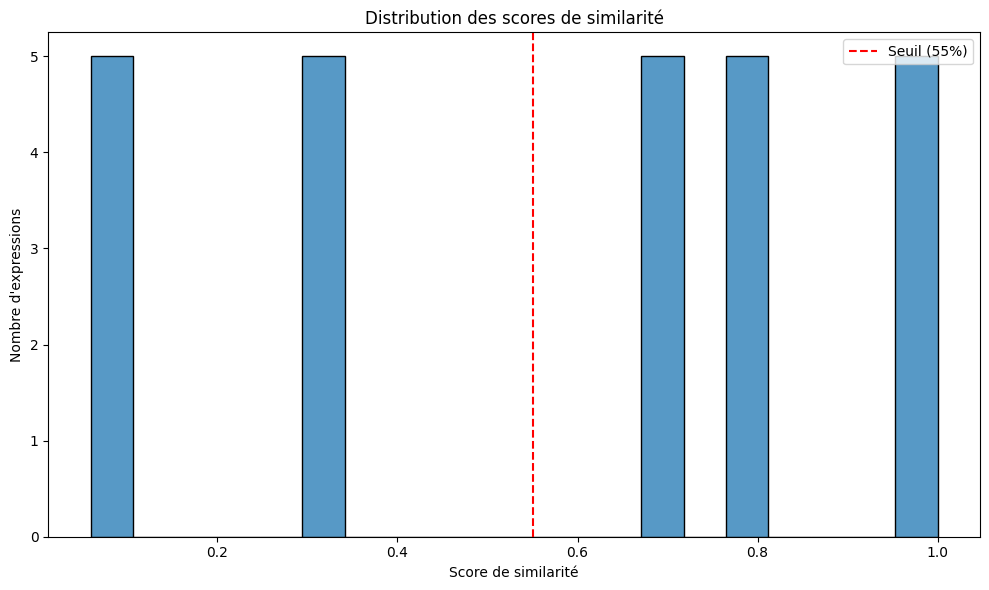

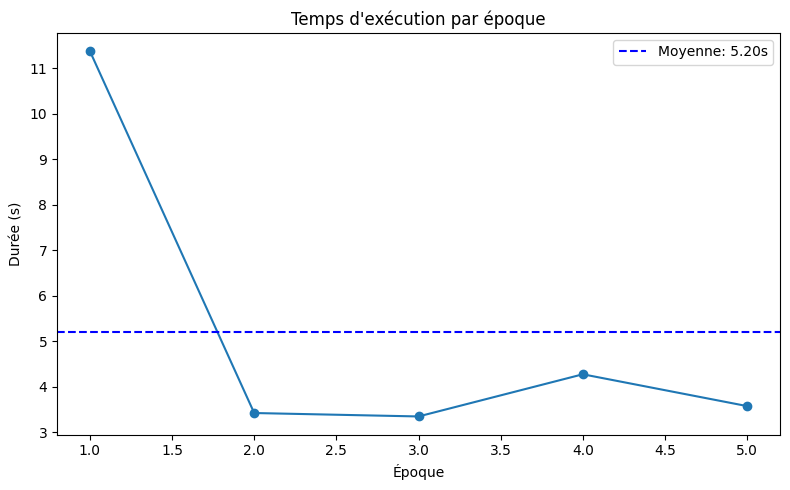

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

TEST_RESULTS_PATH = "testResults/"

def setup_test_dir():
    """Crée le répertoire de résultats"""
    os.makedirs(TEST_RESULTS_PATH, exist_ok=True)

def process_test_case(test, context, examples, similarity_threshold):
    """
    Traite un cas de test unique

    Args:
        test: Le cas de test à traiter
        context: Le contexte disponible
        examples: Les exemples d'expressions
        similarity_threshold: Seuil de similarité

    Returns:
        dict: Résultat du test
    """
    # Génération et mesure du temps
    start_time = time.time()
    try:
        generated = generate_expression(
            test['query'],
            available_context=context,
            examples=examples
        )
    except Exception as e:
        print(f"Erreur: {str(e)[:100]}...")
        generated = "Erreur API"

    execution_time = time.time() - start_time

    # Calcul des métriques
    similarity = calculate_similarity(test['expected'], generated)
    is_match = similarity >= similarity_threshold

    # Construction du résultat
    return {
        'query': test['query'],
        'expected': test['expected'],
        'generated': generated,
        'similarity': similarity,
        'is_match': is_match,
        'execution_time': execution_time
    }

def write_result_to_file(f, result):
    """
    Écrit un résultat dans un fichier

    Args:
        f: Le fichier ouvert en écriture
        result: Le résultat à écrire
    """
    f.write(f"Query: {result['query']}\n")
    f.write(f"Expected: {result['expected']}\n")
    f.write(f"Generated: {result['generated']}\n")
    f.write(f"Similarité: {result['similarity']:.2%}\n")
    f.write(f"Résultat: {'✅ Match' if result['is_match'] else '❌ No Match'}\n\n")

def calculate_epoch_metrics(epoch_results):
    """
    Calcule les métriques pour une époque

    Args:
        epoch_results: Les résultats de l'époque

    Returns:
        float: Le taux de correspondance
    """
    epoch_df = pd.DataFrame(epoch_results)
    return epoch_df['is_match'].mean() if not epoch_df.empty else 0

def generate_visualizations(all_results, epoch_times, similarity_threshold, epochs):
    """
    Génère les visualisations des résultats

    Args:
        all_results: Tous les résultats de test
        epoch_times: Temps d'exécution par époque
        similarity_threshold: Seuil de similarité
        epochs: Nombre d'époques
    """
    all_df = pd.DataFrame(all_results)

    # 1. Graphique de distribution des similarités
    plt.figure(figsize=(10, 6))
    sns.histplot(data=all_df, x='similarity', bins=20)
    plt.axvline(x=similarity_threshold, color='red', linestyle='--',
                label=f'Seuil ({similarity_threshold:.0%})')
    plt.title('Distribution des scores de similarité')
    plt.xlabel('Score de similarité')
    plt.ylabel("Nombre d'expressions")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{TEST_RESULTS_PATH}distribution_similarite.png")

    # 2. Graphique des temps d'exécution
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), epoch_times, marker='o')
    plt.axhline(np.mean(epoch_times), color='blue', linestyle='--', label=f'Moyenne: {np.mean(epoch_times):.2f}s')
    plt.title('Temps d\'exécution par époque')
    plt.xlabel('Époque')
    plt.ylabel('Durée (s)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{TEST_RESULTS_PATH}temps_execution.png")

def calculate_average_results(query_results):
    """
    Calcule les résultats moyens par requête

    Args:
        query_results: Dictionnaire des résultats par requête

    Returns:
        DataFrame: Résultats moyens
    """
    avg_results = []

    for query, results in query_results.items():
        # Trouver le meilleur résultat
        best_result = max(results, key=lambda x: x['similarity'])

        # Calculer les moyennes
        similarities = [r['similarity'] for r in results]
        is_matches = [r['is_match'] for r in results]

        avg_results.append({
            'query': query,
            'expected': best_result['expected'],
            'best_generated': best_result['generated'],
            'avg_similarity': np.mean(similarities),
            'match_rate': np.mean(is_matches)
        })

    return pd.DataFrame(avg_results)

def run_tests(context, examples, similarity_threshold=0.55, epochs=5):
    """
    Exécute les tests sur plusieurs époques et calcule les moyennes

    Args:
        context: Le contexte disponible pour la génération
        examples: Les exemples d'expressions
        similarity_threshold: Seuil de similarité pour considérer un résultat comme correct
        epochs: Nombre d'époques de test

    Returns:
        DataFrame avec les résultats moyens
    """
    setup_test_dir()

    all_results = []
    epoch_times = []
    start_total = time.time()

    # Données pour calculer les moyennes par requête
    query_results = {}

    # Exécuter les tests pour chaque époque
    for epoch in range(1, epochs + 1):
        print(f"Époque {epoch}/{epochs}...")
        start_epoch = time.time()

        epoch_results = []
        with open(f"{TEST_RESULTS_PATH}resultats_epoch_{epoch}.txt", "w", encoding="utf-8") as f:
            for test in test_cases:
                # Traitement du cas de test
                result = process_test_case(
                    test, context, examples, similarity_threshold
                )

                # Stocker pour les moyennes
                query = test['query']
                if query not in query_results:
                    query_results[query] = []
                query_results[query].append(result)

                # Enregistrer les résultats
                all_results.append(result)
                epoch_results.append(result)

                # Écrire dans le fichier
                write_result_to_file(f, result)

        # Mesurer la durée de l'époque
        duration = time.time() - start_epoch
        epoch_times.append(duration)

        # Calculer et afficher le taux de correspondance pour cette époque
        match_rate = calculate_epoch_metrics(epoch_results)
        print(f"Précision: {match_rate:.2%}")
        print(f"Époque terminée en {duration:.2f}s\n")

    # Calculer et afficher le temps total
    total_time = time.time() - start_total
    print(f"Temps total: {total_time:.2f}s")

    # Calculer les moyennes par requête
    avg_df = calculate_average_results(query_results)
    avg_df.to_csv(f"{TEST_RESULTS_PATH}resultats_moyens.csv", index=False)

    # Résumé global
    print(f"Taux de correspondance moyen: {avg_df['match_rate'].mean():.2%}")
    print(f"Similarité moyenne: {avg_df['avg_similarity'].mean():.2%}")

    # Générer les visualisations
    generate_visualizations(all_results, epoch_times, similarity_threshold, epochs)

    return avg_df

def calculate_similarity(expected, generated):
    """Calcule la similarité entre expressions attendues et générées"""
    # Vérifier l'égalité exacte
    if expected == generated or expected.strip() == generated.strip():
        return 1.0

    # Similarité par embedding
    expected_embedding = get_embedding(expected)
    generated_embedding = get_embedding(generated)

    # Fallback si problème d'embedding
    if not expected_embedding.any() or not generated_embedding.any():
        expected_words = set(expected.split())
        generated_words = set(generated.split())
        return len(expected_words.intersection(generated_words)) / len(expected_words) if expected_words else 0.0

    return float(cosine_similarity([expected_embedding], [generated_embedding])[0][0])

# Utilisation
test_cases = read_file('test_data/test_cases.json')
run_tests(AVAILABLE_CONTEXT, SYMFONY_EXAMPLES, epochs=5)